In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [3]:
bs = 64

In [4]:
path = Path('/home/loickWPJ/data')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
#src split the training set into training set ~ 80% and testing set ~ 20% /parameters changed
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .random_split_by_pct(0.1)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

#   labelsets-based stratification. from https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/67819
# raw_train_df, valid_df = train_test_split(image_df, 
#                  test_size = 0.3, 
#                   # hack to make stratification work                  
#                  stratify = image_df['Target'].map(lambda x: x[:3] if '27' not in x else '0'))

In [7]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [8]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [9]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [10]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [11]:
test_fnames[:5]

[PosixPath('/home/loickWPJ/data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/loickWPJ/data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/loickWPJ/data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/loickWPJ/data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/loickWPJ/data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [12]:
#add test set to src
src.add_test(test_fnames, label='0');

In [13]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [14]:
#means, variance for each channel of dataset
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [15]:
#transformations
#no orientation in images
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [16]:
# out of memory error with size 512
#data with transformation
data = (src.transform((trn_tfms, _), size=224) 
        .databunch().normalize(protein_stats))

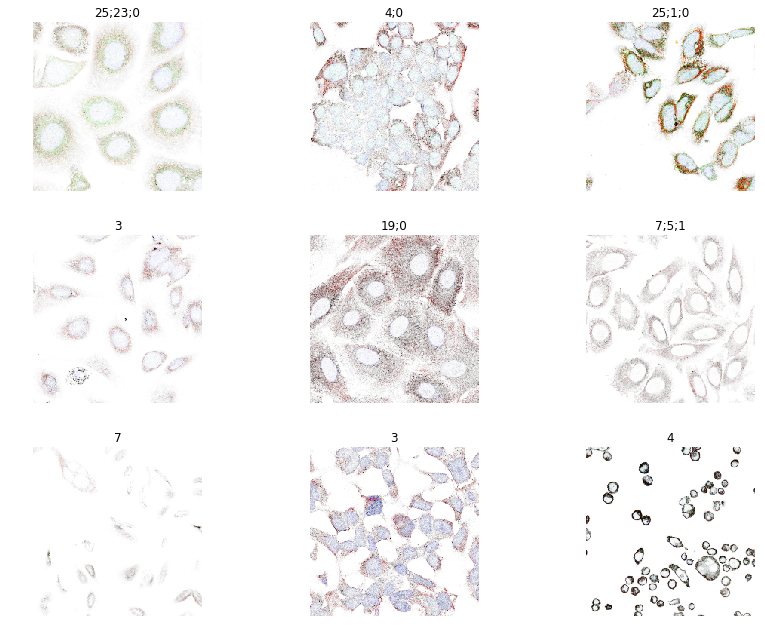

In [17]:
#Some images
data.show_batch(rows=3, figsize=(12,9))

In [18]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [19]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
    
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()


In [21]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [22]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score],
    ps= 0.5 # added dropout 50%
)

In [ ]:
#learn.opt_fn = optim.Adam
#learn.clip = 1.0 #gradient clipping
#learn.crit = FocalLoss()
#learn.precompute = True

In [ ]:
learn.save('temp')

In [ ]:
learn.load('temp')

In [ ]:
learn.precompute=True
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-2
learn.fit_one_cycle(3, lr)

In [ ]:
learn.precompute = False

In [ ]:
learn.fit_one_cycle(3, lr)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(2, slice(lr/9,lr/3,lr))

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.save('temp2')

In [25]:
learn.load('temp2')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 1, MultiCategory 18, MultiCategory 25;2]...
Path: /home/loickWPJ/data
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/loickWPJ/data;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 2;0, MultiCategory 4, MultiCategory 26, MultiCategory 7;0, MultiCategory 23]...
Path: /home/loickWPJ/data
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/loickWPJ/data;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: /home/loickWPJ/data
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Imag

In [26]:
lr = 6e-3

In [27]:
__all__ = ['GeneralScheduler', 'TrainingPhase']

@dataclass
class TrainingPhase():
    "Schedule `lrs` and `moms` according to `lr_anneal` and `mom_anneal` across a `length` schedule."
    length:int
    lrs:Floats
    moms:Floats
    lr_anneal:AnnealFunc=None
    mom_anneal:AnnealFunc=None

    def __post_init__(self)->None:
        self.lr_step = Stepper(self.lrs, self.length, self.lr_anneal)
        self.mom_step = Stepper(self.moms, self.length, self.mom_anneal)

@dataclass
class GeneralScheduler(Callback):
    "Schedule multiple `TrainingPhase` for a `Learner`."
    learn:Learner
    phases:Collection[TrainingPhase]

    def on_train_begin(self, n_epochs:int, **kwargs:Any)->None:
        "Initialize the lr and mom schedules for training."
        self.lr_scheds = [p.lr_step for p in self.phases]
        self.mom_scheds = [p.mom_step for p in self.phases]
        self.opt = self.learn.opt
        self.opt.lr,self.opt.mom = self.lr_scheds[0].start,self.mom_scheds[0].start
        self.idx_s = 0

    def on_batch_end(self, train, **kwargs:Any)->None:
        "Take a step in lr,mom sched, start next stepper when the current one is complete."
        if train:
            if self.idx_s >= len(self.lr_scheds): return True
            self.opt.lr = self.lr_scheds[self.idx_s].step()
            self.opt.mom = self.mom_scheds[self.idx_s].step()
            if self.lr_scheds[self.idx_s].is_done:
                self.idx_s += 1

In [28]:
def fit_sgd_warm(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [TrainingPhase(n * (cycle_len * cycle_mult**i), lr, mom, lr_anneal=annealing_cos) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    learn.fit(total_epochs)

In [29]:
#parameters : learn, n_cycles, lrt, mom, cycle_len, cycle_mult
fit_sgd_warm(learn, 2, 1e-3, 0.9, 1, 2)

Total time: 06:43
epoch  train_loss  valid_loss  fbeta   
1      0.101130    0.093909    0.673197  (02:17)
2      0.100668    0.092841    0.681079  (02:12)
3      0.099299    0.092412    0.682201  (02:12)



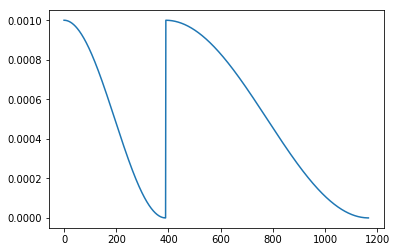

In [30]:
learn.recorder.plot_lr()

In [ ]:
learn.fit(10,slice(lr/9,lr/3,lr))

In [ ]:
learn.save("last")

In [ ]:
learn.load('last')

### TTA

In [ ]:
#log_preds,y = learn.TTA(is_test=True)
#probs = np.mean(np.exp(log_preds),0) # not ready how to incorporate?

In [ ]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) #max works better for F1 macro score

In [ ]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [ ]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

In [ ]:
save_pred(pred_t,th_t,'protein_classification_f.csv')


In [ ]:
preds,_ = learn.get_preds(DatasetType.Test)

In [ ]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv('protein_predictions_datablocks.csv', header=True, index=False)

In [ ]:
#!kaggle competitions submit human-protein-atlas-image-classification -f protein_predictions_datablocks.csv -m "sumbission"